# Sod's Shock tube

## Introduction
Dans ce projet, nous allons résoudre les équations au dérivées partielles couplées suivantes:
$$\frac{\delta}{\delta t}\underline{u}+\frac{\delta}{\delta x}\underline{f}=0$$

Où
$$
\underline{u}=
\left[
\begin{align*}
\rho\\
\rho u\\
\rho e_T
\end{align*}
\right]
$$
  Et
$$
\underline{f}=
\left[
\begin{align*}
\rho u\\
\rho u²+p\\
(\rho e_T+p)u\\
\end{align*}
\right]
$$ 
où $p=(\gamma-1)\left(u_3-\frac{1}{2}\frac{u_2^2}{u_1}\right)$
et $e_T=\frac{p}{(\gamma-1)\rho}+\frac{1}{2}u²$,
les $u_i$ étant les composantes du vecteur
$\underline{u}$

## Analyse numérique - "Richtmyer method"

Commençons par importer les packages habituels, numpy pour certaines fonctions mathématiques et mathplotlib pour les représenttions graphiques

In [270]:
import numpy                       
from matplotlib import pyplot                 
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

Ici nous insérons certains paramètres du code donnés dans l'énoncé

In [271]:
nx = 81       #nombre de points dans l'espace discrétisé pour aller de -10 à 10m
dx = 0.25     #distance entre deux points de l'espace discrétisé en m
dt = .0002    #distance entre deux points du temps discrétisé en s
T=.01         #temps total d'observation du phénomène
nt=int(T/dt)  #il faudra e tout (T/dt)=50 pas de 0.0002 s pour en arriver à 0,01 s
gamma=1.4     #pour un gaz parfait

Créons dors et déjà un tableau de l' espace discrétisé. Celui ci ira de -10 à 10 m et contiendra 2nx-1=161 valeurs.

Effectivemet, nous avons décidé de diviser chaque pas par 2, pour y faire apparaitre les valeurs "i +/- 1/2" ^résentes dans l'algorithme de Richtmyer. Ainsi nous avons nx-1 valeurs qui se rajoutent et le pas vaut 0,125 (comme on l'observe bien sur le "print" suivant). On comprendra par la suite que cela ne change rien à la valeur "dx" de l'algorithme, et notons que d'autres méthodes pourraient ne pas utiliser cet artifice.

In [272]:
x=numpy.linspace(-10,10,2*nx-1)
print(x)

[-10.     -9.875  -9.75   -9.625  -9.5    -9.375  -9.25   -9.125  -9.
  -8.875  -8.75   -8.625  -8.5    -8.375  -8.25   -8.125  -8.     -7.875
  -7.75   -7.625  -7.5    -7.375  -7.25   -7.125  -7.     -6.875  -6.75
  -6.625  -6.5    -6.375  -6.25   -6.125  -6.     -5.875  -5.75   -5.625
  -5.5    -5.375  -5.25   -5.125  -5.     -4.875  -4.75   -4.625  -4.5
  -4.375  -4.25   -4.125  -4.     -3.875  -3.75   -3.625  -3.5    -3.375
  -3.25   -3.125  -3.     -2.875  -2.75   -2.625  -2.5    -2.375  -2.25
  -2.125  -2.     -1.875  -1.75   -1.625  -1.5    -1.375  -1.25   -1.125
  -1.     -0.875  -0.75   -0.625  -0.5    -0.375  -0.25   -0.125   0.
   0.125   0.25    0.375   0.5     0.625   0.75    0.875   1.      1.125
   1.25    1.375   1.5     1.625   1.75    1.875   2.      2.125   2.25
   2.375   2.5     2.625   2.75    2.875   3.      3.125   3.25    3.375
   3.5     3.625   3.75    3.875   4.      4.125   4.25    4.375   4.5
   4.625   4.75    4.875   5.      5.125   5.25    5.375   5.5  

Ensuite nous créons trois matrices contenant trois lignes et 161 colonnes, $I$ pour les conditions initiales, $U$ qui contiendra les valeurs de $\underline{u}$ et F les valeurs de $\underline{f}$

In [273]:
I=numpy.zeros((3,2*nx-1))
U=numpy.zeros((3,2*nx-1))
F=numpy.zeros((3,2*nx-1))

Implémentons donc les valeurs initiales données dans l'énoncé. nous joignons à celà une représentation graphique des conditions initiales données

In [274]:
for i in range(3):
    if i==0:
        h=1
        k=.125
    elif i==1:
        h=0
        k=0
    else:
        h=100000    #Les pressions sont dirrectement implémetées dans les unités du SI
        k=10000
    for j in range(int((2*nx-2)/2)+1):
        I[i,j]=h
        I[i,int(2*nx-2)-j]=k #int() a été rajouté car les indices doivent être entiers
                             #et python considérant l'expression comme un réel, 
                             #un message d'erreur apparaitra                

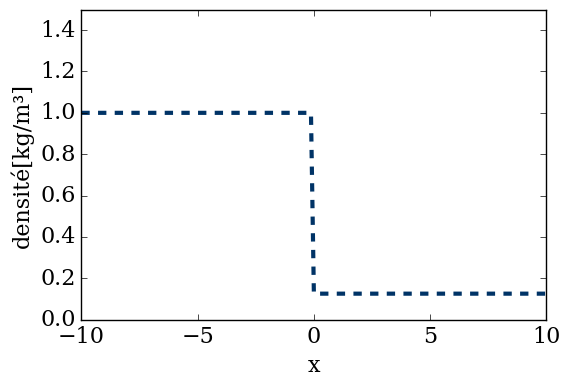

In [275]:
pyplot.plot(x, I[0,], color='#003366', ls='--', lw=3)
pyplot.ylim(0,1.5)
pyplot.xlabel('x', fontsize=16)  #x label
pyplot.ylabel('densité[kg/m³]', fontsize=16)

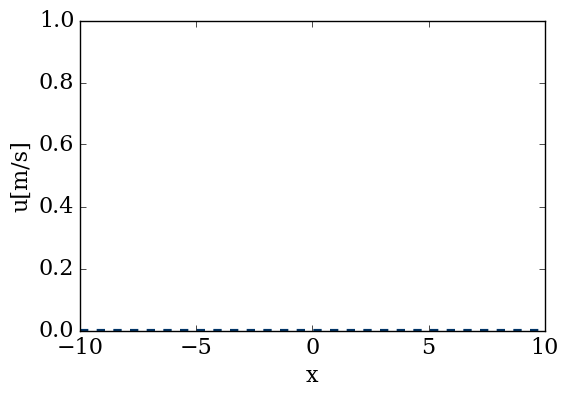

In [276]:
pyplot.plot(x, I[1,], color='#003366', ls='--', lw=3)
pyplot.ylim(0,1)
pyplot.xlabel('x', fontsize=16)  #x label
pyplot.ylabel('u[m/s]', fontsize=16)

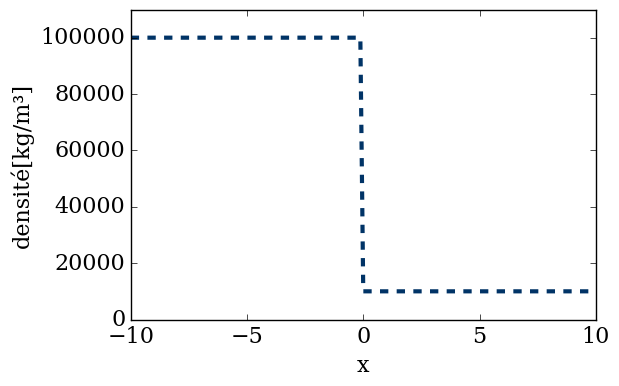

In [277]:
pyplot.plot(x, I[2,], color='#003366', ls='--', lw=3)
pyplot.ylim(0,110000)
pyplot.xlabel('x', fontsize=16)  #x label
pyplot.ylabel('densité[kg/m³]', fontsize=16)

Les conditions initiales nous permettent d'initialiser $U$

In [278]:
for i in range(3):
        for j in range(2*nx-1):
            if i==0:
                U[i,j]=I[i,j]
            if i==1:
                U[i,j]=I[i-1,j]*I[i,j]
            if i==2:
                U[i,j]=I[i-2,j]*((I[i,j]/((gamma-1)*I[i-2,j]))+0.5*(I[i-1,j]**2))

Et $F$, par les relations suivantes liant les composantes de $\underline{f}$ a celles de $\underline{u}$ (données dans les rappels théoriques)

$$
\underline{f}=
\left[
\begin{align*}
u_2\\
\frac{u_2^2}{u_1}+(\gamma-1)\left(u_3-\frac{1}{2}\frac{u_2^2}{u_1}\right)\\
\left(u_3+(\gamma-1)\left(u_3-\frac{1}{2}\frac{u_2^2}{u_1}\right)\right)\frac{u_2}{u_1}\\
\end{align*}
\right]
$$ 


In [279]:
for i in range(3):
        for j in range(2*nx-1):
            if i==0:
                F[i,j]=U[i+1,j]
            if i==1:
                F[i,j]=(U[i,j]**2/U[i-1,j])+(gamma-1)*(U[i+1,j]-0.5*(U[i,j]**2/U[i-1,j]))
            if i==2:
                F[i,j]=(U[i,j]+(gamma-1)*(U[i,j]-0.5*(U[i-1,j]**2/U[i-2,j])))*(U[i-1,j]/U[i-2,j])

Notons bien que étant donné que, de manière générale, $F_i=F_i(u_1,u_2,u_3)$, nous ne pouvons guère les créer "en même temps", sans quoi les $F_i$ prendraient des valeurs erronées. (*)

Ensuite nous appliquons l'algorithme a proprement parler, décrit dans l'énoncé :
$$\underline{u}^{n+\frac{1}{2}}_{i+\frac{1}{2}}=\frac{1}{2}(\underline{u}^{n}_{i+1}+\underline{u}^{n}_{i})-\frac{\Delta t}{2\Delta x}(\underline{f}^{n}_{i+1}-\underline{f}^{n}_{i})$$
$$\underline{u}^{n+1}_{i}=\underline{u}^{n}_{i}-\frac{\Delta t}{\Delta x}(\underline{f}^{n+\frac{1}{2}}_{i+\frac{1}{2}}-\underline{u}^{n+\frac{1}{2}}_{i-\frac{1}{2}})$$

In [280]:
for n in range(nt): #je fais l'algorithme nt=50 fois pour arriver au temps voulu
    for i in range(3): #chaque ligne de la matrice doit être changée
        for j in range(0,2*nx-2,2): 
            U[i,j+1]=(0.5*(U[i,j+2]+U[i,j]))-(dt/(2*dx))*(F[i,j+2]-F[i,j])
    
    for i in range(3):    
        for j in range(0,2*nx-2,2):    
            if i==0:
                F[i,j+1]=U[i+1,j+1]
            if i==1:
                F[i,j+1]=(U[i,j+1]**2/U[i-1,j+1])+(gamma-1)*(U[i+1,j+1]-0.5*(U[i,j+1]**2/U[i-1,j+1]))
            if i==2:
                F[i,j+1]=(U[i,j+1]+(gamma-1)*(U[i,j+1]-0.5*(U[i-1,j+1]**2/U[i-2,j+1])))*(U[i-1,j+1]/U[i-2,j+1])
    
    for i in range(3):
        for j in range(2,2*nx-2,2):
            U[i,j]=U[i,j]-(dt/dx)*(F[i,j+1]-F[i,j-1])
        
    for i in range(3):
        for j in range(0,2*nx,2):    
            if i==0:
                F[i,j]=U[i+1,j]
            if i==1:
                F[i,j]=(U[i,j]**2/U[i-1,j])+(gamma-1)*(U[i+1,j]-0.5*(U[i,j]**2/U[i-1,j]))
            if i==2:
                F[i,j]=(U[i,j]+(gamma-1)*(U[i,j]-0.5*(U[i-1,j]**2/U[i-2,j])))*(U[i-1,j]/U[i-2,j])
    

NB: premièrement, la remarque (*) est aussi applicable dans ce cas. Ensuite, on remarque que le pas des boucles est ici de 2, ce qui est nécessaire car les valeurs "i +/- $\frac{1}{2}$" sont intrinsèques à nos tableaux!


## Simulation results

Toutes les réponses seront ici calculées en $t=0.01$s

Toutes les questions étant ici demandées e x=2.5 m, nous commençons par créer une fonction qui nous renverra l'indice de la colonne contenant les données en x=2.5 m

In [281]:
def NT(t): 
    t2=t+10
    t3=int(t2/0.125)
    return t3

Nous joindront a chaque réponse un graphique qui représentera la variable en fonction de l'espace discrétisé, pour voir comment celles-ci ont évoluées par rapport aux conditions initiales

### question 1
"Enter the velocity at x = 2.5 m in m/s"

En vertu des relations données dans l'introduction, on a que $u=u_2/u_1$

In [282]:
u=U[1,NT(2.5)]/U[0,NT(2.5)]
print(u,"m/s")

292.611471527 m/s


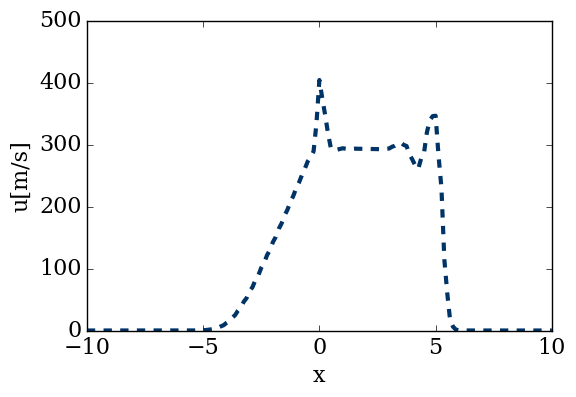

In [283]:
u2=U[1,]/U[0,]
pyplot.plot(x, u2, color='#003366', ls='--', lw=3)
pyplot.ylim(0,500)
pyplot.xlabel('x', fontsize=16)  #x label
pyplot.ylabel('u[m/s]', fontsize=16) 

### question 2
"Enter the pressure at x = 2.5 m in N/m²"


En vertu des relations données dans l'introduction, on a que $p=\frac{\underline f_3}{u}-\rho e_T=\frac{\underline f_3}{u}-u_3$

In [284]:
p=(F[2,NT(2.5)]/u)-U[2,NT(2.5)]
print(p,"N/m²")

30250.8901676 N/m²


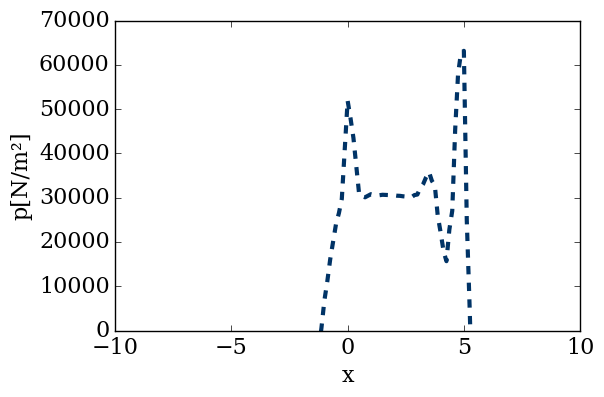

In [285]:
p2=(F[2,]/u)-U[2,]
pyplot.plot(x, p2, color='#003366', ls='--', lw=3)
pyplot.ylim(0,70000);
pyplot.xlabel('x', fontsize=16)  #x label
pyplot.ylabel('p[N/m²]', fontsize=16) 

### question 3
"Enter the density at x = 2.5 m in kg/m$^3$"


La densité est directement données dans la ligne $u_1$

In [286]:
rho=U[0,NT(2.5)]
print(rho,"kg/m³") #le message d'erreur m'avertit juste que la fonction va foirer si je mes pas un entier

0.374691402648 kg/m³


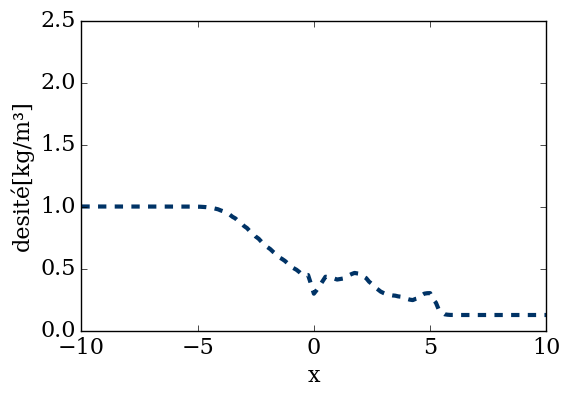

In [287]:
pyplot.plot(x, U[0,], color='#003366', ls='--', lw=3)
pyplot.ylim(0,2.5);
pyplot.xlabel('x', fontsize=16)  #x label
pyplot.ylabel('desité[kg/m³]', fontsize=16) 

## Conclusion
Nous avons donc vérifié l'efficacité et le bienfondé de l'algorithme de Richmyer, et observé le comportement du Sod's Shock tube en utilisant le modèle proposé.